# Задание 3. Линейная регрессия

In [ ]:
!git clone https://bitbucket.org/alms/classification-2022/src/master/

fatal: destination path 'master' already exists and is not an empty directory.


Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

In [ ]:
import numpy as np
D = np.loadtxt('/content/master/data/lin_reg.txt', delimiter=',')
X = D[:, :-1]
Y = D[:, -1]

При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
Y = np.expand_dims(Y, axis=0).T

l = X.shape[0]
X = np.hstack((np.ones(shape=(l, 1)), X))

print(f"Y shape: {Y.shape}")
print(f"X shape: {X.shape}")

Y shape: (1000, 1)
X shape: (1000, 5)


In [ ]:
import torch

class linearRegression(torch.nn.Module):
  def __init__(self, inputSize, outputSize):
    super(linearRegression, self).__init__()
    self.linear = torch.nn.Linear(inputSize, outputSize, bias=False)

  def forward(self, x):
    out = self.linear(x)
    # print(f'Выход модели: {out}')
    return out


In [ ]:
def train(model, x_train, y_train, lr=0.01, weight_decay=0.5, epochs=100, print_inf = False):
  x_train = torch.from_numpy(x_train).float()
  y_train = torch.from_numpy(y_train).float()

  # print(f'x_train = {x_train},\ny_train = {y_train}')

  if torch.cuda.is_available():
    device = 'cuda'
    x_train = x_train.to(device)
    y_train = x_train.to(device)
    model.cuda()

  criterion = torch.nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

  for epoch in range(epochs):

    optimizer.zero_grad()

    outputs = model(x_train)

    loss = criterion(outputs, y_train)

    loss.backward()

    optimizer.step()

    if print_inf:
      print(f'epoch {epoch}, loss {loss}')
      print(f'Веса модели: {model.linear.weight}\n')

  # возвращаем последний loss
  return loss.item()

In [ ]:
torch.manual_seed(42)

inputDim = X.shape[1]
outputDim = Y.shape[1]

print(f'Размер входа модели: {inputDim}\nРазмер выхода: {outputDim}\n')

losses = []

for wd in range(0, 101):

  model = linearRegression(inputDim, outputDim)

  model = model.float()

  losses.append(train(model, X, Y, weight_decay = wd, lr=0.0001,  epochs=1000))
  if wd + 1 % 10 == 0:
    print(f'{wd}/100')

Размер входа модели: 5
Размер выхода: 1

1/100
2/100
3/100
4/100
5/100
6/100
7/100
8/100
9/100
10/100
11/100
12/100
13/100
14/100
15/100
16/100
17/100
18/100
19/100
20/100
21/100
22/100
23/100
24/100
25/100
26/100
27/100
28/100
29/100
30/100
31/100
32/100
33/100
34/100
35/100
36/100
37/100
38/100
39/100
40/100
41/100
42/100
43/100
44/100
45/100
46/100
47/100
48/100
49/100
50/100
51/100
52/100
53/100
54/100
55/100
56/100
57/100
58/100
59/100
60/100
61/100
62/100
63/100
64/100
65/100
66/100
67/100
68/100
69/100
70/100
71/100
72/100
73/100
74/100
75/100
76/100
77/100
78/100
79/100
80/100
81/100
82/100
83/100
84/100
85/100
86/100
87/100
88/100
89/100
90/100
91/100
92/100
93/100
94/100
95/100
96/100
97/100
98/100
99/100
100/100
101/100


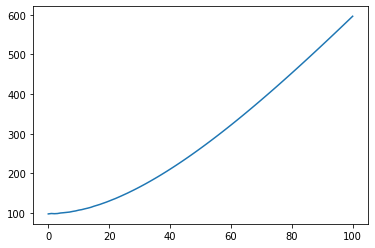

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)

2. Подготовьте исходные данные для 5 fold CV.


In [ ]:
def shuffle_two_arrays(a, b):
  assert len(a) == len(b)
  p = np.random.permutation(len(a))
  return a[p], b[p]

def kfold(a, b, k=5):
  assert len(a) == len(b)
  a, b = shuffle_two_arrays(a, b)
  n = len(a)
  size = n // k

  data = [(a[size * i:size * (i + 1)], b[size * i:size * (i + 1)]) for i in range(k - 1)]
  data.append((a[size * (k - 1):], b[size * (k-1):]))

  return data

In [ ]:
data = kfold(X, Y, k=5)

3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.

In [ ]:
torch.manual_seed(42)

loss = torch.nn.MSELoss()

inputDim = X.shape[1]
outputDim = Y.shape[1]

print(f'Размер входа модели: {inputDim}\nРазмер выхода: {outputDim}\n')

k_losses = []

for i in range(len(data)):
  print(f'Fold {i + 1}\n')
  X_test, Y_test = data[i]
  X_train, Y_train = [], []

  X_test = torch.from_numpy(X_test).float()
  Y_test = torch.from_numpy(Y_test).float()

  for j in range(len(data)):
    if j == i:
      continue
    else:
      X_train = np.concatenate((X, data[j][0]), axis=0)
      Y_train = np.concatenate((Y, data[j][1]), axis=0)

  losses = []
  train_losses = []

  for wd in range(0, 101):
    model = linearRegression(inputDim, outputDim)
    model = model.float()
    train_loss = train(model, X_train, Y_train, weight_decay = wd, lr=0.0001,  epochs=1000)
    with torch.inference_mode(): 
      Y_preds = model(X_test)
    losses.append(loss(Y_preds, Y_test).item()) 
    train_losses.append(train_loss)

    if wd % 10 == 0:
      print(f'{wd}/100')
  k_losses.append(losses)
  print()


mean_losses = np.array(k_losses[0])
for i in range(1, len(k_losses)):
  mean_losses += np.array(k_losses[i])

mean_losses /= 5

best_wd = np.argmin(mean_losses)
print(f'best alpha: {best_wd}\nmean loss: {mean_losses[best_wd]}')

Размер входа модели: 5
Размер выхода: 1

Fold 1

0/100
10/100
20/100
30/100
40/100
50/100
60/100
70/100
80/100
90/100
100/100

Fold 2

0/100
10/100
20/100
30/100
40/100
50/100
60/100
70/100
80/100
90/100
100/100

Fold 3

0/100
10/100
20/100
30/100
40/100
50/100
60/100
70/100
80/100
90/100
100/100

Fold 4

0/100
10/100
20/100
30/100
40/100
50/100
60/100
70/100
80/100
90/100
100/100

Fold 5

0/100
10/100
20/100
30/100
40/100
50/100
60/100
70/100
80/100
90/100
100/100

best alpha: 0
mean loss: 98.02630767822265


4. Постройте валидационную кривую. 

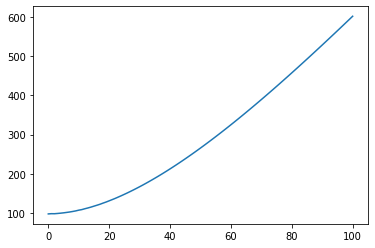

In [ ]:
import matplotlib.pyplot as plt

plt.plot(mean_losses)

5. Постройте кривую обучения.

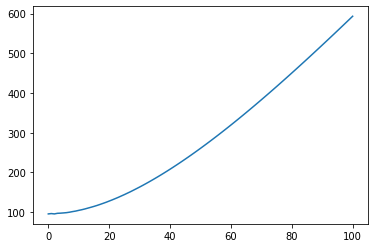

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses)